## Reload

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [85]:
artists=pd.read_csv('../datasets/artists.csv')

G_geo_B_copy = nx.read_gexf("gexf/G_geo_B.gexf")
G_influencedby_B = nx.read_gexf("gexf/G_influencedby_B.gexf")
G_influencedon_B = nx.read_gexf("gexf/G_influencedon_B.gexf")
G_friendsandcoworkers_B_copy = nx.read_gexf("gexf/G_friendsandcoworkers_B.gexf")
G_influencedon_B_copy = nx.read_gexf("gexf/G_influencedon_B2.gexf")
G_artists_B = nx.read_gexf("gexf/G_artists_B.gexf")

## B2) Geographical analysis with time

The main attributes:

- place of birth
- places
- places by years
- nationality

**Macros:**

In [105]:
birthplace_weight = 0.5; places_weight = 0.4; nationality_weight = 0.8
weights = [birthplace_weight,places_weight,nationality_weight]

year_index_threshold = 0
places_threshold = 1.5
styles_threshold = 0.3
time_place_threshold = 0.4
style_threshold = 0.25

**Year index between two artists:**

Number of years the two artists were alive at the same time.<br>
For either artist, if a year is between his birthyear and first year of painting appearing in the dataset, instead of adding 1 year to the count, we add 0.1 (and in the case when this is true for both artists, add 0.01 instead).


In [106]:
def year_index(years1, years2):
    #Year_index: years between first and last year are accounted with weight 1, years between birth and first year are accounted with weight 0.1.
    #For each overlapping year, we add 1 times the weights. Lastly, we divide by the total number of years of the younger artist.
    year_index = 0
    if(years1[0] > years2[0]):
        yearst = years1;years1 = years2;years2 = yearst
    #No overlap
    if(years1[2] < years2[0]):  #Not needed, but better for computation
        return 0
    for year in range((years1)[0], np.min([years1[2],years2[2]])+1):
        c = 1
        if year < years2[0]:
            c = 0
            continue
        if(year<years1[1]):
            c = c*0.2
        if(year<years2[1]):
            c = c*0.2
        year_index += c
    year_index = year_index/(np.min([years1[2]-years1[0],years2[2]-years2[0]])+1)
    return year_index

Matisse_years1=[1869, 1890, 1954]
Picasso_years2=[1881, 1900, 1973]
year_index(Matisse_years1, Picasso_years2)

0.6669767441860465

**Place index between two artists:**

Measure for how close are two artists to each other in terms of places they lived/painted in (and birthplace).<br>

In [107]:
from geopy.geocoders import Nominatim    
geolocator = Nominatim(user_agent="PainterProject")

# Function to get the country from a birthplace
def get_country(birthplace):
    location = geolocator.geocode(birthplace)
    if location:
        return location.address.split(",")[-1].strip()
    return None

In [108]:
def place_index(placescount1, placescount2, birthplace1, birthplace2, nationality1, nationality2):
    #Places index
    i1 = 0; i2 = 0
    if placescount1 is not np.nan and placescount2 is not np.nan:
        places1_count_tuple = [(x.split(":")[0], int(x.split(":")[1])) if ":" in x else (x, 0) for x in placescount1]
        places2_count_tuple = [(x.split(":")[0], int(x.split(":")[1])) if ":" in x else (x, 0) for x in placescount2]
        for tuple1 in places1_count_tuple:
            for tuple2 in places2_count_tuple:
                if(tuple1[0] == tuple2[0]):
                    i1 += tuple1[1]; i2 += tuple2[1]
        sum1 = np.sum([x[1] for x in places1_count_tuple]); sum2 = np.sum([x[1] for x in places2_count_tuple])
        i1 = i1/np.min([sum1,25]); i2 = i2/np.min([sum2,25]) #This allows the places to go over 1, as many paintings in one place suggests a strong connection
        i = np.max([i1,i2])
    else:
        i = 0
    n1 = 0; n2 = 0
    if type(nationality1) == float or type(nationality2) == float:
        n = 0 #One of them is a nan
    else:
        for nat1 in nationality1.split(','):
            for nat2 in nationality2.split(','):
                if(nat1 == nat2):
                    n1 += 1; n2 += 1
        n = n1*n2/len(nationality1.split(','))/len(nationality2.split(','))
    b = 1 if birthplace1 == birthplace2 else 0
        
    """
        #Note: this codes almost always times out.
        else:
        #If they are in the same country, we give a weight of 0.5
        try:
            b = 0.5 if get_country(birthplace1) == get_country(birthplace2) else 0
        except:
            b = 0; print("Error with birthplaces: ", birthplace1, birthplace2)
    """

    return weights[0]*b + weights[1]*i + weights[2]*n


Michelangelo_places_count = [x.replace("{","").replace("}","") for x in artists[artists['artist'] == "Michelangelo"]["PlacesCount"].iloc[0].split(",") if x != '']
Picasso_places_count = [x.replace("{","").replace("}","") for x in artists[artists['artist'] == "Pablo Picasso"]["PlacesCount"].iloc[0].split(",")]
place_index(Michelangelo_places_count, Picasso_places_count, "Caprese", "Malaga", artists[artists['artist'] == "Michelangelo"]["Nationality"].iloc[0], artists[artists['artist'] == "Michelangelo"]["Nationality"].iloc[0])

5.856000000000001

Style index between two artists:

Measure of how similarly two painters painted based on the styles of their paintings.

In [117]:
def style_index(styles_count1, styles_count2, bin_max_threshold=200, min_i_rate_threshold = 0.1, min_max_threshold_rate=0.8):
    """
    Calculate a style index based on the overlap of styles between two lists.

    Parameters:
    - styles_count1: List of tuples containing styles and their counts for artist 1.
    - styles_count2: List of tuples containing styles and their counts for artist 2.
    - threshold: Minimum count of shared artworks in a style for a connection to be considered.

    Returns:
    - Style index between 0 and 1.
    """

    styles_index = 0
    # Styles index
    i1 = 0
    i2 = 0

    if (type(styles_count1) != float) and (type(styles_count2) != float): #If both are not nan
        if styles_count1 and styles_count2:
            for stylecount1 in styles_count1:
                try:
                    style1, count1 = stylecount1.split(":")
                except:
                    continue
                for stylecount2 in styles_count2:
                    try:
                        style2, count2 = stylecount2.split(":")
                    except:
                        continue
                    if style1 == style2:
                        i1 += int(count1)
                        i2 += int(count2)

            sum1 = np.sum([int(x.split(":")[1]) if ":" in x else 0 for x in styles_count1])
            sum2 = np.sum([int(x.split(":")[1]) if ":" in x else 0 for x in styles_count2])

            i1 = i1 / np.max([np.min([sum1, bin_max_threshold]),1]) # Usually percentage, but with many artworks in one style, it can go over 1
            i2 = i2 / np.max([np.min([sum2, bin_max_threshold]),1]) # 1 at the end to avoid division by 0
            if (i1>min_i_rate_threshold) and (i2>min_i_rate_threshold):
                styles_index = np.min([i1, i2])*min_max_threshold_rate+np.max([i1, i2])*(1-min_max_threshold_rate)

    return styles_index

Picasso_styles_count = [x.replace(" {","").replace("{","").replace("}","") for x in artists[artists['artist'] == "Pablo Picasso"]["StylesCount"].iloc[0].split(",")]
Monet_styles_count = [x.replace(" {","").replace("{","").replace("}","") for x in artists[artists['artist'] == "Claude Monet"]["StylesCount"].iloc[0].split(",")]
style_index(Monet_styles_count, Picasso_styles_count)

1.5369999999999997

### Create G_geo_B (time and place) and G_time_place_style_B

In [118]:
G_geo_B = nx.Graph(); G_geo_B_copy.add_nodes_from(artists['artist'])
G_time_place_style_B = nx.Graph(); G_time_place_style_B.add_nodes_from(artists['artist'])

In [119]:
for i in range(len(artists['artist'])):
    artist1 = artists['artist'].iloc[i]
    geo_style_data1 = artists[artists['artist']==artist1].reset_index().loc[0][['birth_place','Nationality','Places', 'PlacesYears','PlacesCount','PaintingSchool','birth_year', 'FirstYear','LastYear', 'StylesCount']]
    years1 = [geo_style_data1['birth_year'], geo_style_data1['FirstYear'], geo_style_data1['LastYear']]
    if (np.isnan(years1[0])) or (np.isnan(years1[1])) or (np.isnan(years1[2])):
        continue
    for j in range(i+1, len(artists['artist'])):
        artist2 = artists['artist'].iloc[j]
        geo_style_data2 = artists[artists['artist']==artist2].reset_index().loc[0][['birth_place','Nationality','Places', 'PlacesYears','PlacesCount','PaintingSchool','birth_year', 'FirstYear','LastYear','StylesCount']]
        years2 = [geo_style_data2['birth_year'], geo_style_data2['FirstYear'], geo_style_data2['LastYear']]
        if (np.isnan(years2[0])) or (np.isnan(years2[1])) or (np.isnan(years2[2])):
            continue
        #Year index
        year_index_val = year_index([int(year) for year in years1], [int(year) for year in years2])
        #Place index
        places1 = geo_style_data1["PlacesCount"]; places2 = geo_style_data2["PlacesCount"]
        if((places1 is not np.nan) & (places2 is not np.nan)):
            places1m = [x.replace("{","").replace("}","") for x in places1.split(",") if x != '']
            places2m = [x.replace("{","").replace("}","") for x in places2.split(",") if x != '']
        else:
            places1m = np.nan; places2m = np.nan
        birthplace1 = geo_style_data1["birth_place"]; birthplace2 = geo_style_data2["birth_place"]
        nationality1= geo_style_data1['Nationality']; nationality2 = geo_style_data2['Nationality']
        place_index_val = place_index(places1m, places2m, birthplace1, birthplace2, nationality1, nationality2)
        if (year_index_val > year_index_threshold) and (place_index_val > places_threshold) and (place_index_val*year_index_val > time_place_threshold):
            G_geo_B.add_edge(artist1, artist2, weight=year_index_val*place_index_val)
            nx.set_edge_attributes(G_geo_B, {(artist1, artist2): year_index_val}, 'year_index')
            nx.set_edge_attributes(G_geo_B, {(artist1, artist2): place_index_val}, 'place_index')
            #Style index
            styles1 = geo_style_data1["StylesCount"]; styles2 = geo_style_data2["StylesCount"]
            if((styles1 is not np.nan) & (styles2 is not np.nan)):
                styles1m = [x.replace("{","").replace("}","") for x in styles1.split(",") if x != '']
                styles2m = [x.replace("{","").replace("}","") for x in styles2.split(",") if x != '']
            else:
                styles1m = np.nan; styles2m = np.nan
            style_index_val = style_index(styles1m, styles2m)
            if style_index_val > styles_threshold:
                G_time_place_style_B.add_edge(artist1, artist2, weight=style_index_val*year_index_val*place_index_val)
                nx.set_edge_attributes(G_time_place_style_B, {(artist1, artist2): style_index_val}, 'style_index')

G_geo_B_filtered = G_geo_B.copy()
G_geo_B_filtered.remove_nodes_from(list(nx.isolates(G_geo_B_filtered)))
G_time_place_style_B_filtered = G_time_place_style_B.copy()
G_time_place_style_B_filtered.remove_nodes_from(list(nx.isolates(G_time_place_style_B_filtered)))


<details><summary><u>if one wants to first construct G_geo_B then remove edges from it to create G_styles_B</u></summary>

```python

#Update the style_index of the edges in G_style_B
G_style_B = G_geo_B_filtered.copy()

for edge in G_style_B.edges():
    artist1, artist2 = edge
    year_index_val = G_geo_B[artist1][artist2]['year_index']
    place_index_val = G_geo_B[artist1][artist2]['place_index']

    styles1 = artists[artists['artist']==artist1].reset_index().loc[0]["StylesCount"]; styles2 = artists[artists['artist']==artist2].reset_index().loc[0]["StylesCount"]
    style_index_val = 0
    if((styles1 is not np.nan) & (styles2 is not np.nan)):
        styles1m = [x.replace("{","").replace("}","") for x in styles1.split(",") if x != '']
        styles2m = [x.replace("{","").replace("}","") for x in styles2.split(",") if x != '']
        style_index_val = style_index(styles1m, styles2m)
    
    if style_index_val < styles_threshold:
        G_style_B.remove_edge(artist1, artist2)
    else:
        nx.set_edge_attributes(G_style_B, {(artist1, artist2): style_index_val}, 'style_index')

```

</details>


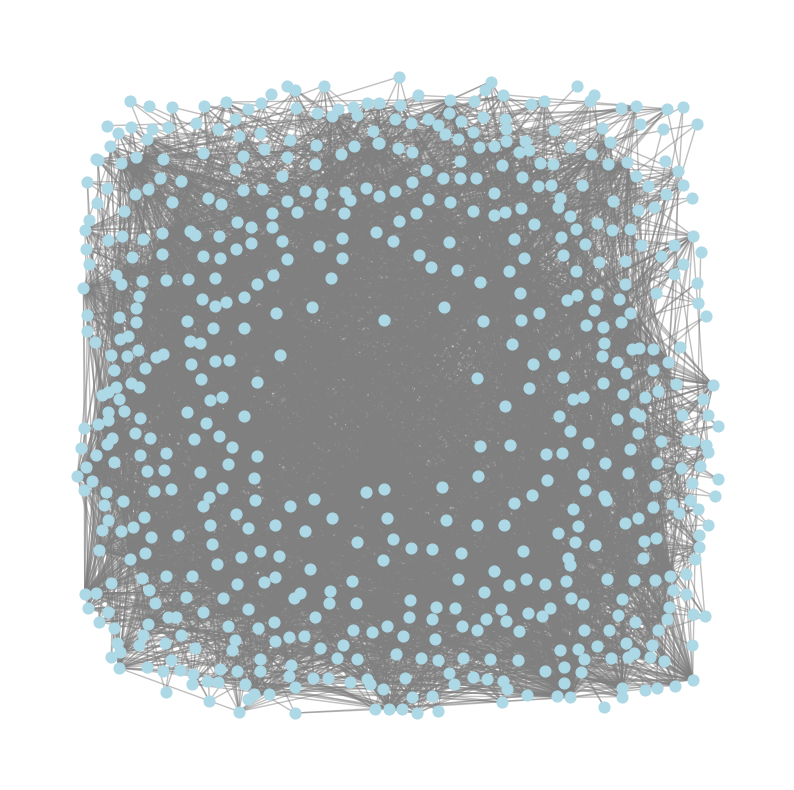

In [141]:
def plot_graph(G, pos, node_size=60, node_color='lightblue', edge_color='gray', width=1, edge_alpha=0.5, labels=False):
    plt.figure(figsize=(10,10))
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
    nx.draw_networkx_edges(G, pos, width=width,alpha=edge_alpha, edge_color=edge_color)
    plt.axis('off')
    plt.show()

plot_graph(G_geo_B_filtered, nx.spring_layout(G_geo_B_filtered, k=0.9, iterations=3))


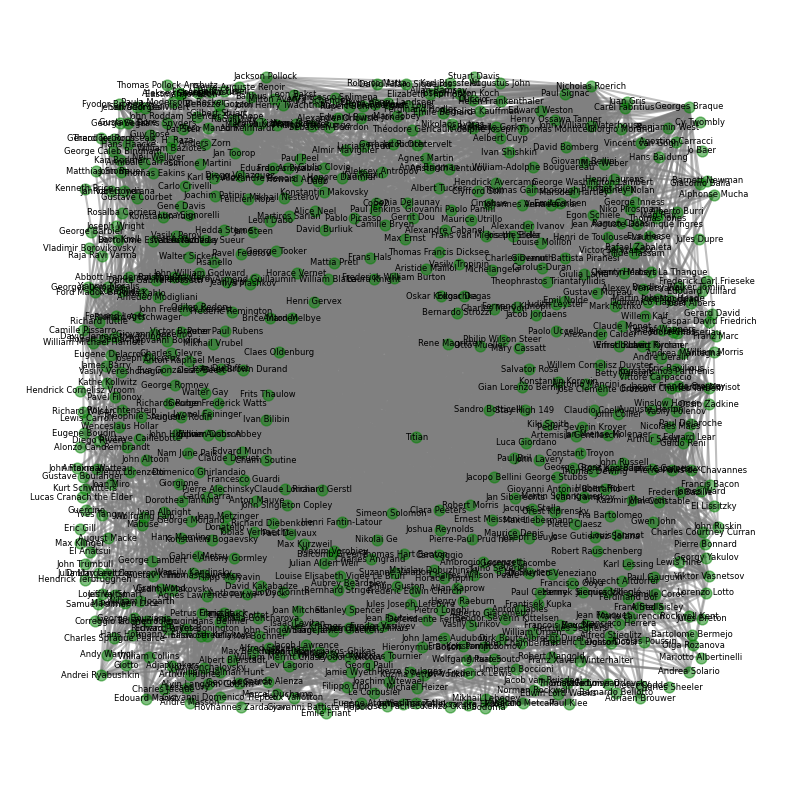

In [120]:
#Plot G_geo_B_filtered
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_geo_B_filtered, k=0.9, iterations=2)
nx.draw_networkx_edges(G_geo_B_filtered, pos, width=1.5, alpha=0.5, edge_color='grey')
nx.draw_networkx_nodes(G_geo_B_filtered, pos, node_size=60, node_color='green', alpha=0.5)
nx.draw_networkx_labels(G_geo_B_filtered, pos, font_size=6, font_family='sans-serif', font_color='black',)
plt.axis('off')
plt.show()


Gephi drawing (earlier version with minor differences):

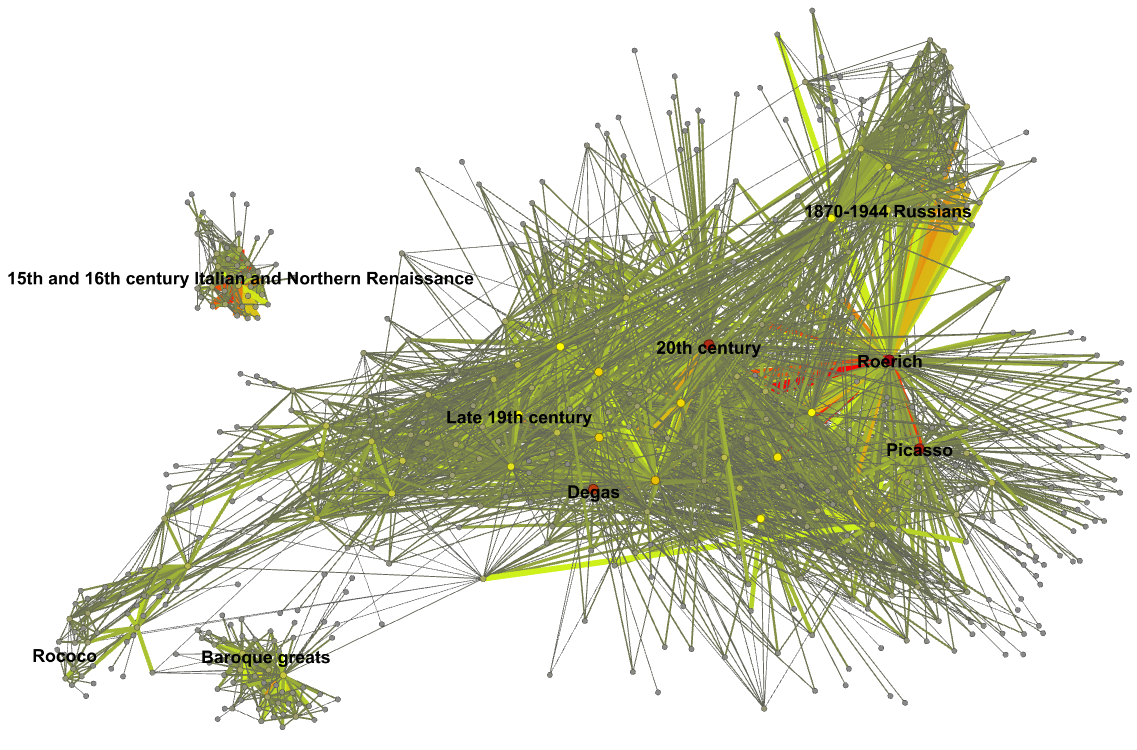

In [142]:
#Save graph to Gephi
nx.write_gexf(G_geo_B_filtered, "gexf/G_geo_B.gexf")

### Reload

In [2]:
G_geo_B_filtered = nx.read_gexf("gexf/G_geo_B.gexf")

### Different thresholds

In [143]:
def create_subgraph(graph_with_edgeweights,edge_threshold):
    G = nx.Graph()
    for edge in graph_with_edgeweights.edges():
        if graph_with_edgeweights[edge[0]][edge[1]]['weight'] > edge_threshold:
            G.add_edge(edge[0],edge[1])
    return G

G_geo_B_filtered = nx.read_gexf("gexf/G_geo_B.gexf")
G_geo_B_filtered_2half = create_subgraph(G_geo_B_filtered,2.5)
G_geo_B_filtered_one = create_subgraph(G_geo_B_filtered,1)


In [146]:
nx.write_gexf(G_geo_B_filtered_2half,"gexf/G_geo_B_filtered_2half.gexf")
nx.write_gexf(G_geo_B_filtered_one,"gexf/G_geo_B_filtered_one.gexf")

In [145]:
births = [int(artists[artists['artist'] == artist]['birth_year'].iloc[0]) for artist in G_geo_B_filtered_one.nodes()]
firsts = [int(artists[artists['artist'] == artist]['FirstYear'].iloc[0]) for artist in G_geo_B_filtered_one.nodes()]
lasts = [int(artists[artists['artist'] == artist]['LastYear'].iloc[0]) for artist in G_geo_B_filtered_one.nodes()]

nx.set_node_attributes(G_geo_B_filtered_one, dict(zip(G_geo_B_filtered_one.nodes(), births)), 'birth_year')
nx.set_node_attributes(G_geo_B_filtered_one, dict(zip(G_geo_B_filtered_one.nodes(), firsts)), 'first_year')
nx.set_node_attributes(G_geo_B_filtered_one, dict(zip(G_geo_B_filtered_one.nodes(), lasts)), 'last_year')

# Order of birth_year
birth_years = sorted(births)
birth_years_order = [birth_years.index(birth_year) + 1 for birth_year in births]
birth_years_order_dict = dict(zip(G_geo_B_filtered_one.nodes(), birth_years_order))
nx.set_node_attributes(G_geo_B_filtered_one, birth_years_order_dict, 'birth_year_order_1_to_N')

#Add artist movement to nodes
movement_dict = {artist: artists[artists['artist'] == artist]['movement'].iloc[0] for artist in G_geo_B_filtered_one.nodes()}
nx.set_node_attributes(G_geo_B_filtered_one, movement_dict, 'movement')



# Save graph to Gephi
nx.write_gexf(G_geo_B_filtered_one, "gexf/G_geo_B_filtered_one_mod.gexf")

Gephi drawing (earlier version with minor differences):

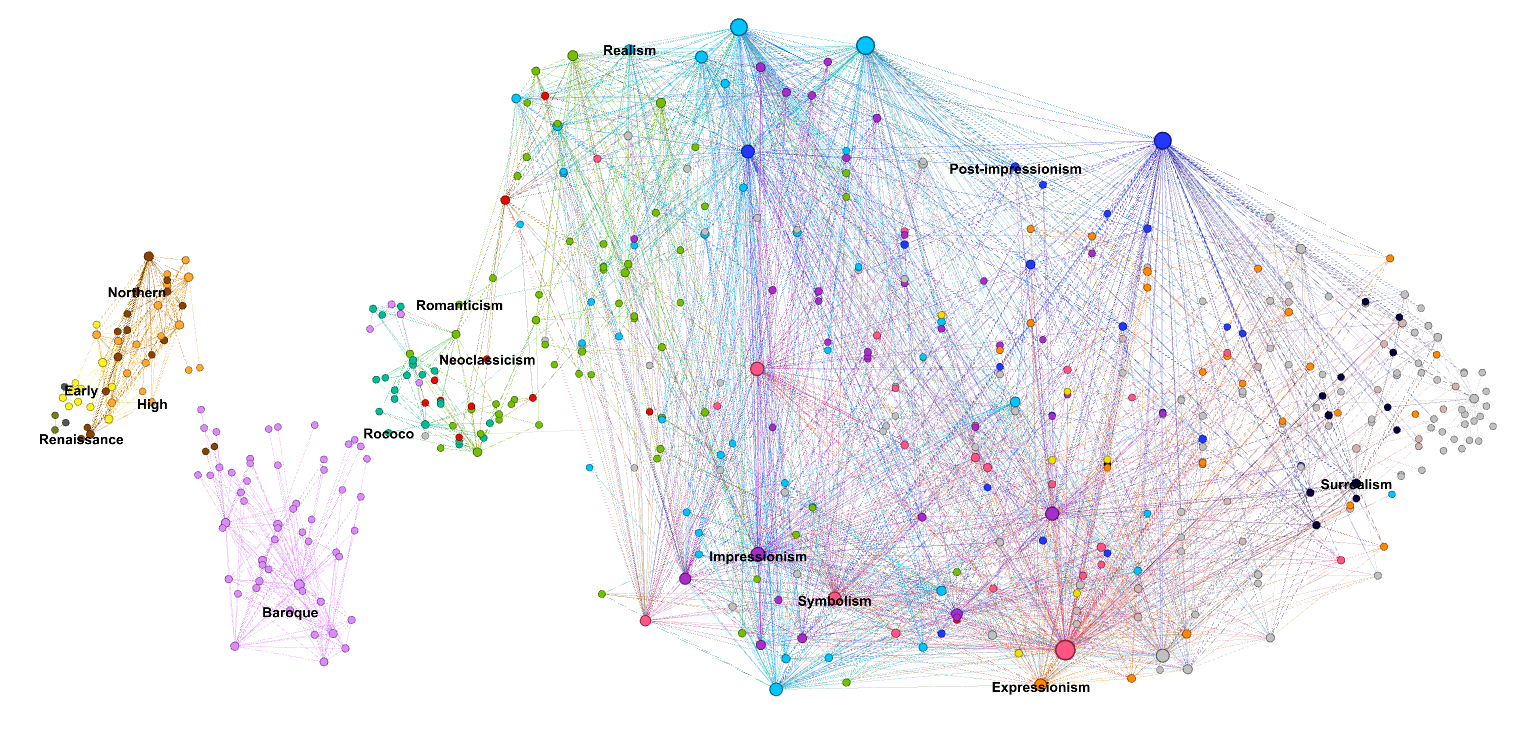

### Dynamic analysis

Periods:

1) Renaissance (1400-1600)
2) Baroque (1600-1700)
3) Rococo (1700-1750)
4) Neoclassicism (1750-1850)
5) Romanticism (1800-1850)
6) Realism (1848-1900)
7) Impressionism (1860-1900)
8) Post-Impressionism (1880-1910)
9) Expressionism (1905-1920)

Analysis:

0) Total graph:

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 510; 2806 | 11.004 | 3.000 | 0.769 | 0.022 | 0.548

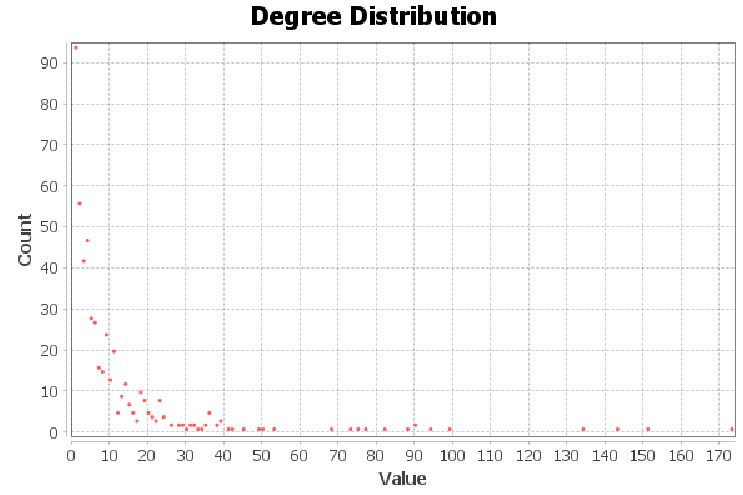

1) Renaissance:

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 47; 207 | 7.600 | 2.121 | 0.715 | 0.224 | 0.260

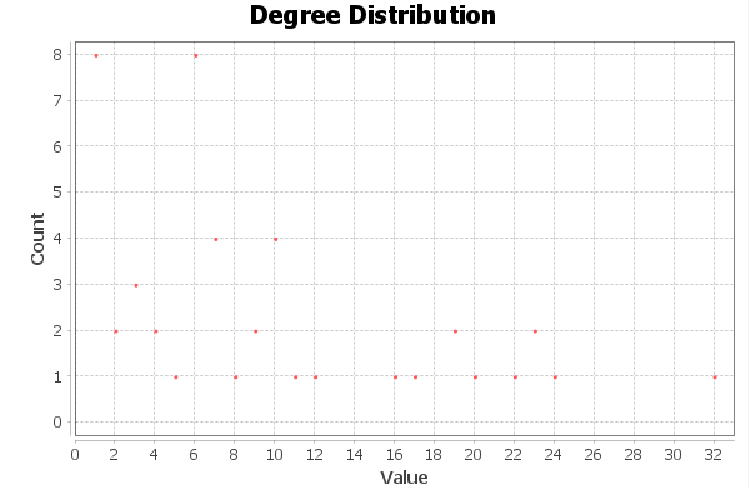

2) Baroque:

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 57; 197 | 7.036 | 2.064 | 0.794 | 0.128 | 0.233 

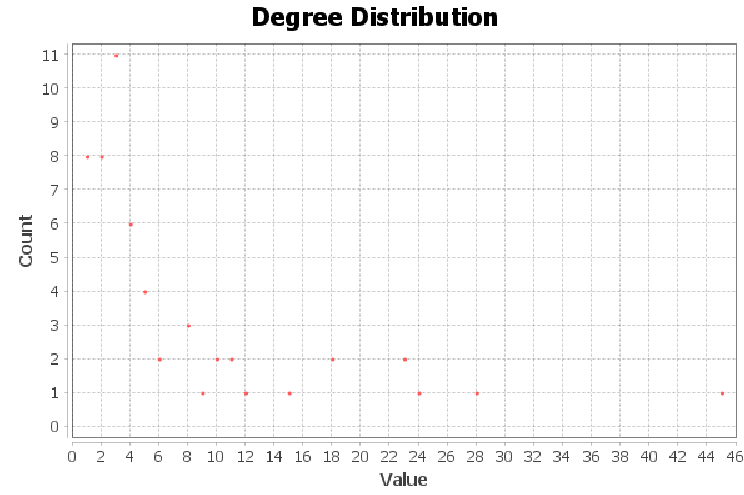

3) Rococo, early Romanticism:

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 53; 127 | 4.792 | 2.467 | 0.674 | 0.092 | 0.353

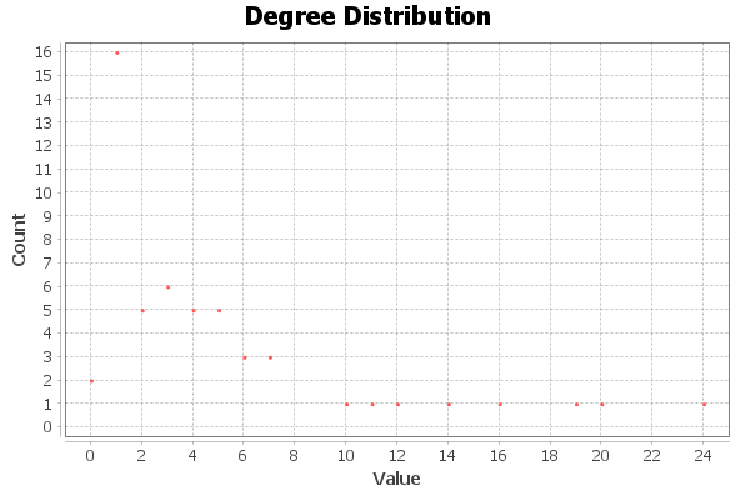

4) Romanticism, early Realism (artists born between 1790 and 1840):

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 75; 289 | 7.707 | 2.217 | 0.769 | 0.104 | 0.352

 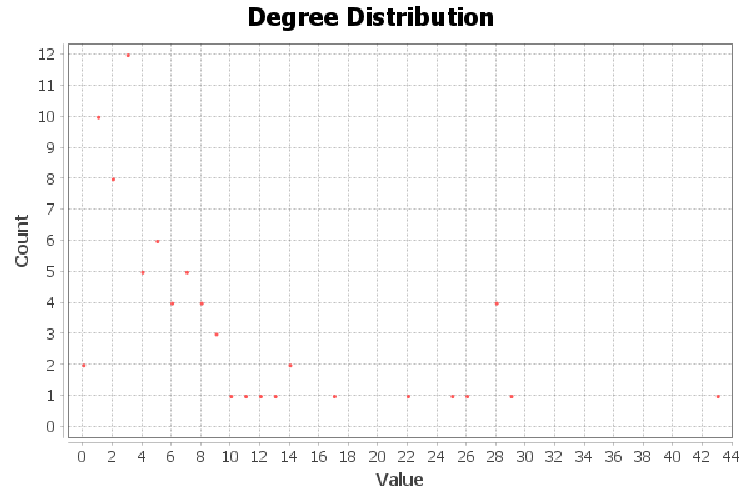

5) Realism, Impressionism:

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 53; 206 | 7.774 | 2.074 | 0.809 | 0.149 | 0.305

 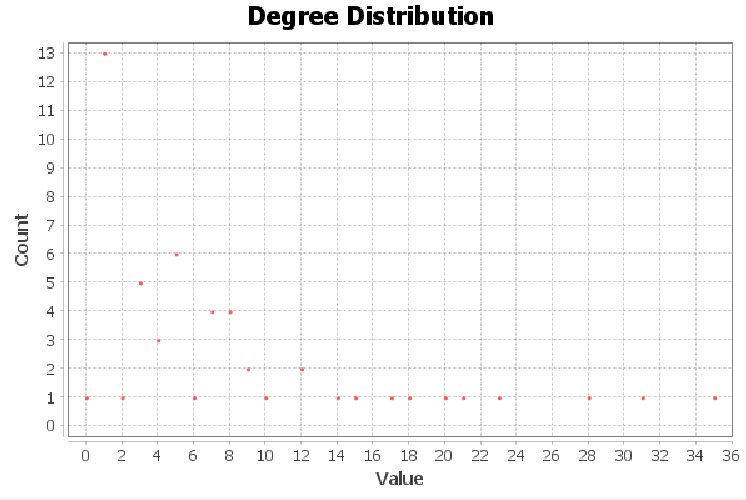

6) Impressionism, Neo/Post-Impressionism, Symbolism (artists born between 1857-1870, active roughly between 1880-1910):

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 60; 77 | 2.567 | 2.217 | 0.696 | 0.044 | 0.343

 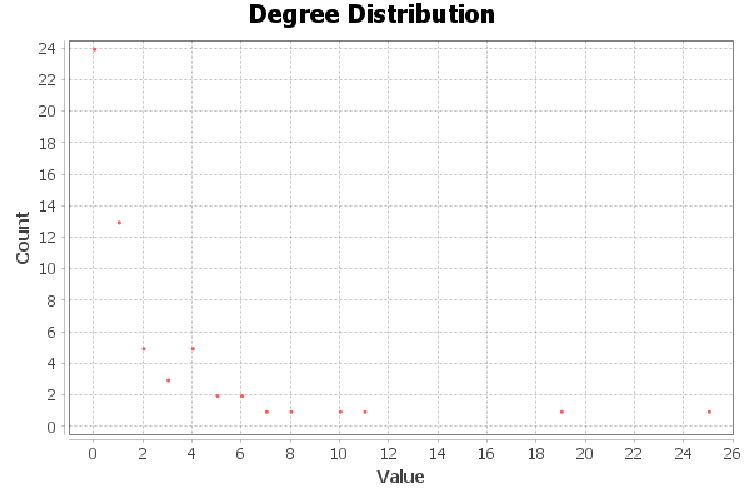

7) Expressionism, Post-Impressionism, Abstract Art (artists born between 1870-1885, active roughly between 1905-1938):

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 60; 143 | 4.767 | 2.090 | 0.835 | 0.081 | 0.306

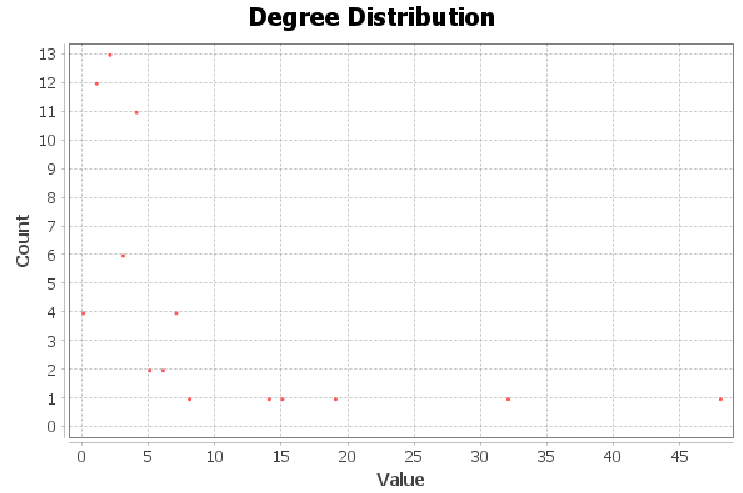

8) Abstract Art, Surrealism, Expressionism (artists born between 1885-1920, active roughly between 1920-1940):

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 66; 101 | 3.061 | 2.512 | 0.575 | 0.047 | 0.351

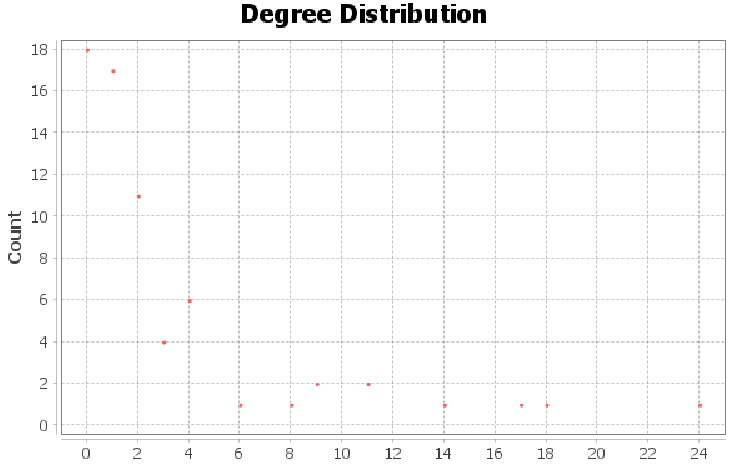

9) Contemporary Art (artists born between 1920-1950, active roughly between 1940-2010):

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 40; 45 | 2.250 | 1.933 | 0.884 | 0.058 | 0.146

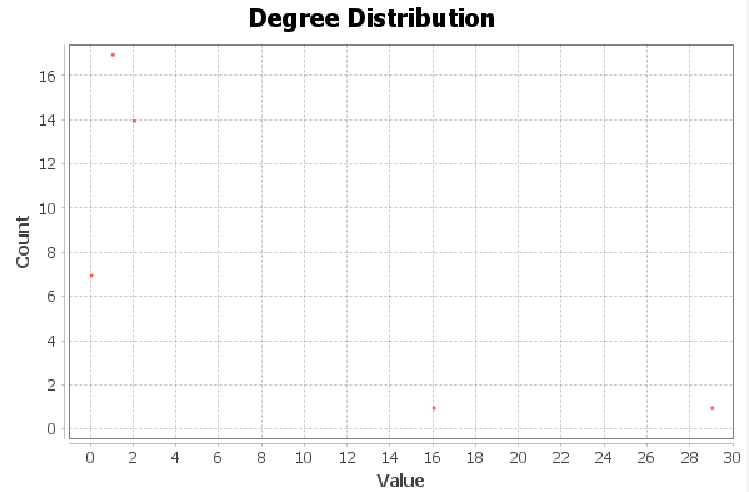

 +1) Birthyears 1789(1796)-1853 (realism, impressionism painters era): 

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 122; 694 | 11.377 | 2.372 | 0.769 | 0.094 | 0.341

 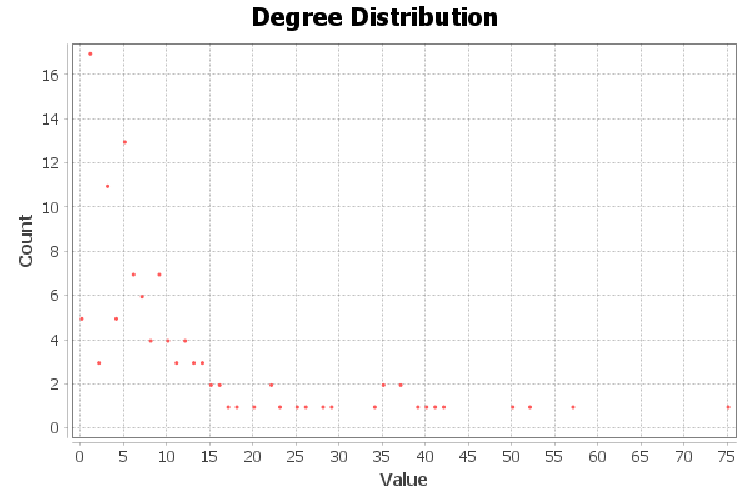

 +2) From Rococo to now:

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 407; 2402 | 11.803 | 3.029 | 0.773 | 0.029 | 0.439

 +3) From 1789 (1796) to now:

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 354; 2238 | 12.644 | 2.61 | 0.785 | 0.036 | 0.393

 +4) From 1857 to now:

Nodes; edges | Average degree | Average path length | Average clustering coefficient | Graph density | Modularity
--- | --- | --- | --- | --- | ---
 226; 858 | 7.593 | 2.483 | 0.791 | 0.034 | 0.337

 +5) Art Nouveau:
